In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import cabinetry
import pyhf
import json

In [2]:
file = uproot.open('/nfs/dust/belle2/user/lorenzg/Summer_workshop_2023/Ntuple_tagV.root')

In [3]:
file.keys()

['B;1']

In [4]:
file['B;1']

<TTree 'B' (116 branches) at 0x7f12d0363a00>

In [5]:
file.classnames()

{'B;1': 'TTree'}

In [6]:
events = uproot.open('/nfs/dust/belle2/user/lorenzg/Summer_workshop_2023/Ntuple_tagV.root:B;1')

In [7]:
events.keys()

['__experiment__',
 '__run__',
 '__event__',
 '__production__',
 '__candidate__',
 '__ncandidates__',
 '__MCDecayString__',
 '__weight__',
 'Ecms',
 'B_CMS_px',
 'B_CMS_py',
 'B_CMS_pz',
 'B_CMS_pt',
 'B_CMS_p',
 'B_CMS_E',
 'B_px',
 'B_py',
 'B_pz',
 'B_pt',
 'B_p',
 'B_E',
 'B_Mbc',
 'B_deltaE',
 'B_isContinuumEvent',
 'B_R2',
 'B_thrustBm',
 'B_thrustOm',
 'B_cosTBTO',
 'B_cosTBz',
 'B_KSFWV_et',
 'B_KSFWV_mm2',
 'B_KSFWV_hso00',
 'B_KSFWV_hso01',
 'B_KSFWV_hso02',
 'B_KSFWV_hso03',
 'B_KSFWV_hso04',
 'B_KSFWV_hso10',
 'B_KSFWV_hso12',
 'B_KSFWV_hso14',
 'B_KSFWV_hso20',
 'B_KSFWV_hso22',
 'B_KSFWV_hso24',
 'B_KSFWV_hoo0',
 'B_KSFWV_hoo1',
 'B_KSFWV_hoo2',
 'B_KSFWV_hoo3',
 'B_KSFWV_hoo4',
 'B_CC1',
 'B_CC2',
 'B_CC3',
 'B_CC4',
 'B_CC5',
 'B_CC6',
 'B_CC7',
 'B_CC8',
 'B_CC9',
 'B_foxWolframR1',
 'B_foxWolframR4',
 'B_thrustAxisCosTheta',
 'B_DeltaZ',
 'B_DeltaZErr',
 'B_TagVReChi2',
 'B_TagVReChi2IP',
 'B_TagVx',
 'B_TagVxErr',
 'B_TagVy',
 'B_TagVyErr',
 'B_TagVz',
 'B_TagVzErr',

In [8]:
deltaE = events.arrays(['B_isSignal', 'K_isSignal', 'pi_isSignal', 'B_mcPDG', 'K_mcPDG', 'pi_mcPDG', 'B_isContinuumEvent', 'B_mcErrors', 'B_deltaE'], library='pd').query('B_deltaE < 0.3 and B_deltaE > -0.3')

In [9]:
deltaE

,B_isSignal,K_isSignal,pi_isSignal,B_mcPDG,K_mcPDG,pi_mcPDG,B_isContinuumEvent,B_mcErrors,B_deltaE
60,0.0,1.0,0.0,300553.0,-321.0,300553.0,False,304.0,-0.193159
66,0.0,1.0,0.0,300553.0,-321.0,300553.0,False,432.0,-0.193238
72,0.0,1.0,0.0,300553.0,-321.0,300553.0,False,304.0,-0.189536
77,0.0,1.0,0.0,300553.0,-321.0,300553.0,False,304.0,-0.192058
80,0.0,1.0,0.0,300553.0,-321.0,300553.0,False,304.0,-0.181249
...,...,...,...,...,...,...,...,...,...
7860093,0.0,1.0,0.0,300553.0,321.0,300553.0,False,304.0,-0.217566
7860097,0.0,1.0,0.0,300553.0,321.0,300553.0,False,304.0,-0.218705
7860098,1.0,1.0,1.0,521.0,321.0,111.0,False,0.0,0.066826
7860099,0.0,1.0,0.0,300553.0,321.0,300553.0,False,304.0,-0.202619


In [10]:
cond_kpi = 'B_isSignal==1'
cond_pipi = 'abs(B_mcPDG)==521 and B_mcErrors==128 and abs(K_mcPDG)==211'
cond_qqbar = 'B_isContinuumEvent==1'

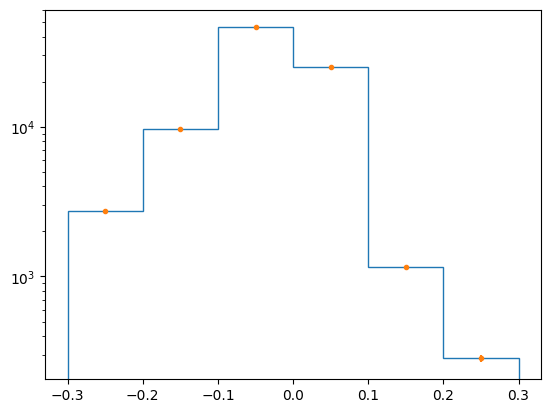

In [11]:
# plt.hist(deltaE.query(cond_kpi)['B_deltaE'].tolist(), bins=50, histtype='step')
events, bins, _ = plt.hist(deltaE.query(cond_kpi)['B_deltaE'].tolist(), bins=np.linspace(-0.3, 0.3, 7).tolist(), histtype='step')
plt.errorbar((bins[1:] + bins[:-1])/2, events, yerr=np.sqrt(events), fmt='.')
plt.yscale('log')


In [12]:
cabinetry.set_logging()

config = {
   "General":{
      "Measurement": "minimal_example",
      "POI": "Signal_norm",              # parameter of interest, which we want to measure 
      "InputPath": "/nfs/dust/belle2/user/lorenzg/Summer_workshop_2023/{SamplePath}", # where to find input data
      "HistogramFolder": "histograms/"

   }
}

config.update({
   "Regions":[
      {
         "Name": "Signal_region",
         "Filter": "B_deltaE > -0.3 and B_deltaE < 0.3",           # event selection 
         "Variable": "B_deltaE",                 
         "Binning": np.linspace(-0.3, 0.3, 50).tolist(),
      }
   ]
})

config.update({
   "Samples":[
      {
         "Name": "Data",
         "Tree": "B;1",
         "SamplePath": "Ntuple_tagV.root",
         "Filter": "B_isSignal==1",
         "Data": True                       # observed data is handled differently, need to distinguish
      },
      {
         "Name": "Signal",
         "Tree": "B;1",
         "SamplePath": "Ntuple_tagV.root",
         "Filter": "B_isSignal==1",
      },
   ]
})



config.update({
   "Systematics":[

   ],
})



config.update({
   "NormFactors":[
      {
         "Name": "Signal_norm",
         "Samples": "Signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-10, 10]
      }
   ]
})

cabinetry.configuration.validate(config)
cabinetry.configuration.print_overview(config)


INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   2 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   0 Systematic(s)


In [13]:
cabinetry.templates.build(config, method="uproot")
cabinetry.templates.postprocess(config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal


DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal.npz
DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal_modified.npz


INFO - cabinetry.visualize - visualizing histogram
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_prefit.pdf


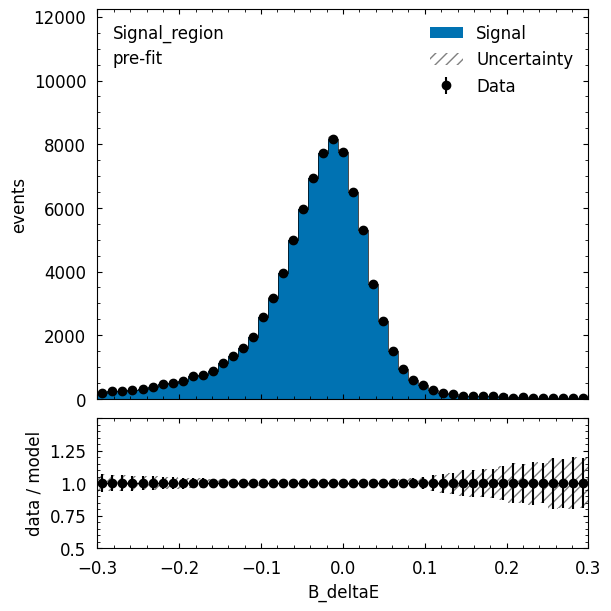

In [14]:
_ = cabinetry.visualize.data_mc_from_histograms(config, log_scale=False)

In [15]:
workspace_path = "example_workspace.json"
spec = cabinetry.workspace.build(config)
cabinetry.workspace.save(spec, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region Signal_region
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to example_workspace.json


In [16]:
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "Signal_region",
            "samples": [
                {
                    "data": [
                        195.0,
                        248.0,
                        263.0,
                        291.0,
                        324.0,
                        378.0,
                        452.0,
                        513.0,
                        567.0,
                        706.0,
                        753.0,
                        877.0,
                        1124.0,
                        1337.0,
                        1612.0,
                        1959.0,
                        2587.0,
                        3163.0,
                        3951.0,
                        4998.0,
                        5977.0,
                        6952.0,
                        7719.0,
                        8157.0,
                        7768.0,
                        6502.0,
                        5295.0,
        

In [17]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_Signal_region (49 new nuisance parameters)


In [18]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 180.2                      │             Nfcn = 3168              │
│ EDM = 1.99e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 180.173901 at 

In [19]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

Signal_norm: 1.000 +/- 0.005
staterror_Signal_region[0]: 1.000 +/- 0.051
staterror_Signal_region[1]: 1.000 +/- 0.045
staterror_Signal_region[2]: 1.000 +/- 0.044
staterror_Signal_region[3]: 1.000 +/- 0.042
staterror_Signal_region[4]: 1.000 +/- 0.039
staterror_Signal_region[5]: 1.000 +/- 0.036
staterror_Signal_region[6]: 1.000 +/- 0.033
staterror_Signal_region[7]: 1.000 +/- 0.031
staterror_Signal_region[8]: 1.000 +/- 0.030
staterror_Signal_region[9]: 1.000 +/- 0.027
staterror_Signal_region[10]: 1.000 +/- 0.026
staterror_Signal_region[11]: 1.000 +/- 0.024
staterror_Signal_region[12]: 1.000 +/- 0.021
staterror_Signal_region[13]: 1.000 +/- 0.019
staterror_Signal_region[14]: 1.000 +/- 0.018
staterror_Signal_region[15]: 1.000 +/- 0.016
staterror_Signal_region[16]: 1.000 +/- 0.014
staterror_Signal_region[17]: 1.000 +/- 0.013
staterror_Signal_region[18]: 1.000 +/- 0.012
staterror_Signal_region[19]: 1.000 +/- 0.010
staterror_Signal_region[20]: 1.000 +/- 0.009
staterror_Signal_region[21]: 1.000 +

/nfs/dust/belle2/user/lorenzg/venv_pyhf/lib/python3.8/site-packages/cabinetry/visualize/plot_result.py:109: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([-0.5, num_pars - 0.5])
INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


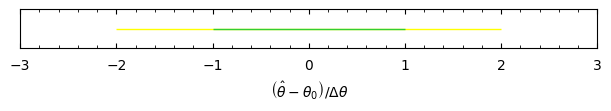

In [20]:
cabinetry.visualize.pulls(fit_results, exclude="Signal_norm")

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


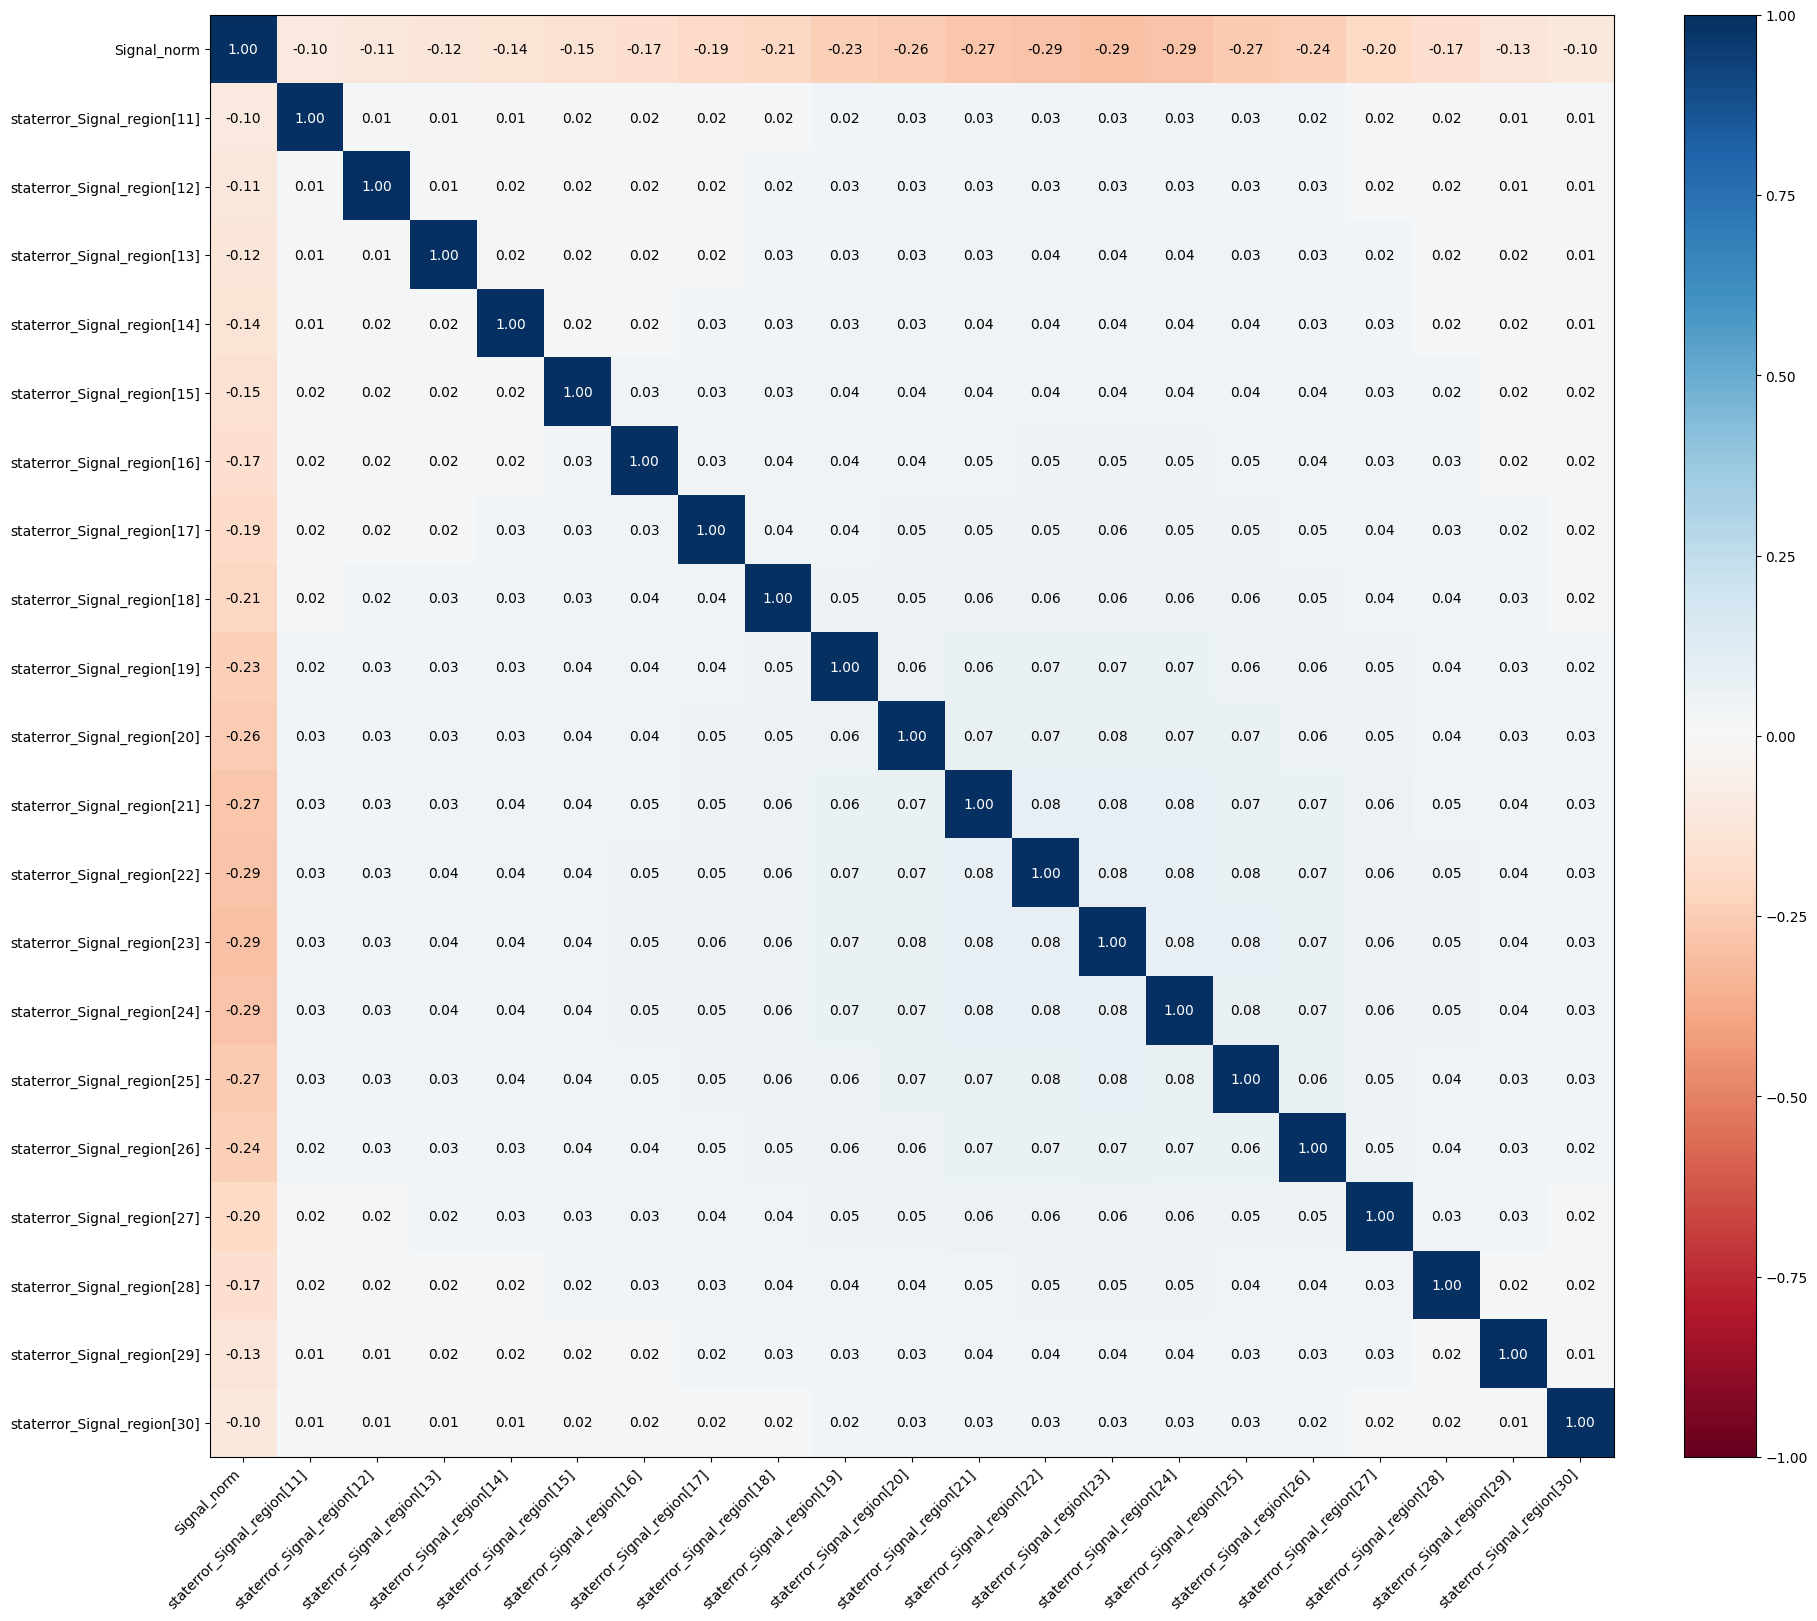

In [21]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.1)

In [22]:
model_pred = cabinetry.model_utils.prediction(model)
_ = cabinetry.tabulate.yields(model_pred, data)

DEBUG - cabinetry.model_utils - total stdev is [[14, 15.7, 16.2, 17.1, 18, 19.4, 21.3, ..., 6.63, 6, 6.4, 5.1, 5.29, 5, 5.2]]
DEBUG - cabinetry.model_utils - total stdev per channel is [292]
INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒══════════╤═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤══════════════╤══════════════╤══════════════╤══════════════╤══════════════╤═

DEBUG - cabinetry.model_utils - total stdev is [[9.88, 11.2, 11.5, 12.1, 12.8, 13.8, ..., 4.24, 4.53, 3.6, 3.74, 3.53, 3.67]]
DEBUG - cabinetry.model_utils - total stdev per channel is [292]
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_postfit_log.pdf


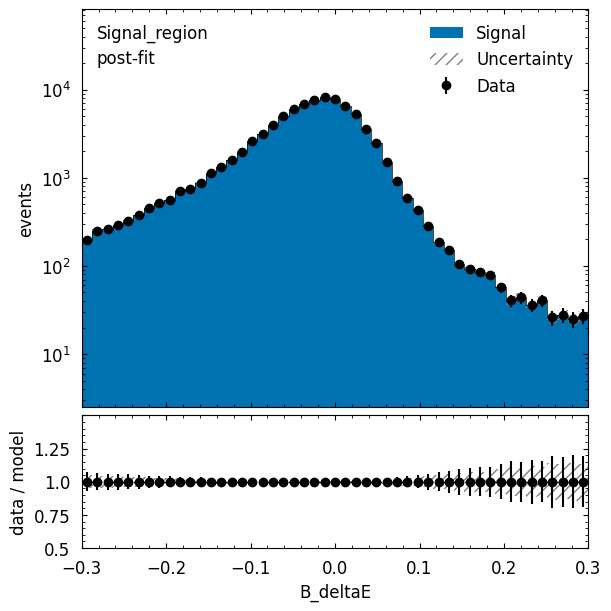

In [23]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=config)

In [24]:


asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)


INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 180.2                      │             Nfcn = 3168              │
│ EDM = 1.99e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 180.173901 at 

In [25]:
asimov_data

[195.0,
 248.0,
 263.0,
 291.0,
 324.0,
 378.0,
 452.0,
 513.0,
 567.0,
 706.0,
 753.0,
 877.0,
 1124.0,
 1337.0,
 1612.0,
 1959.0,
 2587.0,
 3163.0,
 3951.0,
 4998.0,
 5977.0,
 6952.0,
 7719.0,
 8157.0,
 7768.0,
 6502.0,
 5295.0,
 3624.0,
 2459.0,
 1500.0,
 927.0,
 593.0,
 433.0,
 284.0,
 186.0,
 151.0,
 105.0,
 92.0,
 85.0,
 79.0,
 57.0,
 41.0,
 44.0,
 36.0,
 41.0,
 26.0,
 28.0,
 25.0,
 27.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [26]:
import copy
smoothing_config = copy.deepcopy(config)
smoothing_config["General"]["HistogramFolder"] = "histograms_smoothing/"
smoothing_config.update({
   "Systematics":[
      {
         "Name":"Modeling",
         "Up": {"SamplePath": "prediction.root", "Tree": "background_varied"},
         "Down": {"Symmetrize": True},
         "Samples": "Background",
         "Smoothing": {"Algorithm": "353QH, twice"},  # smoothing applied
         "Type": "NormPlusShape"
      }
   ]
})
cabinetry.templates.build(smoothing_config, method="uproot")
cabinetry.templates.postprocess(smoothing_config)
_ = cabinetry.visualize.templates(smoothing_config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal


DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Signal.npz
DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Signal_modified.npz
INFO - cabinetry.visualize - visualizing systematic templates


In [27]:
scan_results = cabinetry.fit.scan(model, data, "Signal_norm", n_steps=5)

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 180.2                      │             Nfcn = 3168              │
│ EDM = 1.99e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 180.173901 at 

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 180.2                      │             Nfcn = 3054              │
│ EDM = 1.28e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 180.173901 at 

INFO - cabinetry.visualize.utils - saving figure as figures/scan_Signal_norm.pdf


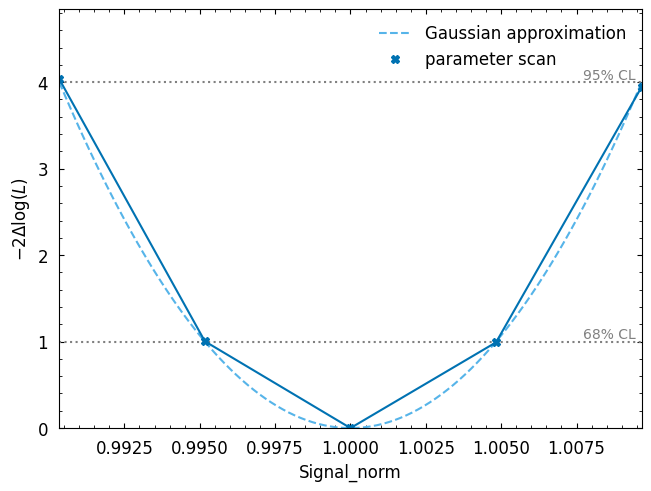

In [28]:
cabinetry.visualize.scan(scan_results)

In [29]:
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results)

INFO - cabinetry.fit - calculating impact of staterror_Signal_region[0] on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 182.1                      │             Nfcn = 3190              │
│ EDM = 4.86e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───

INFO - cabinetry.visualize.utils - saving figure as figures/ranking.pdf


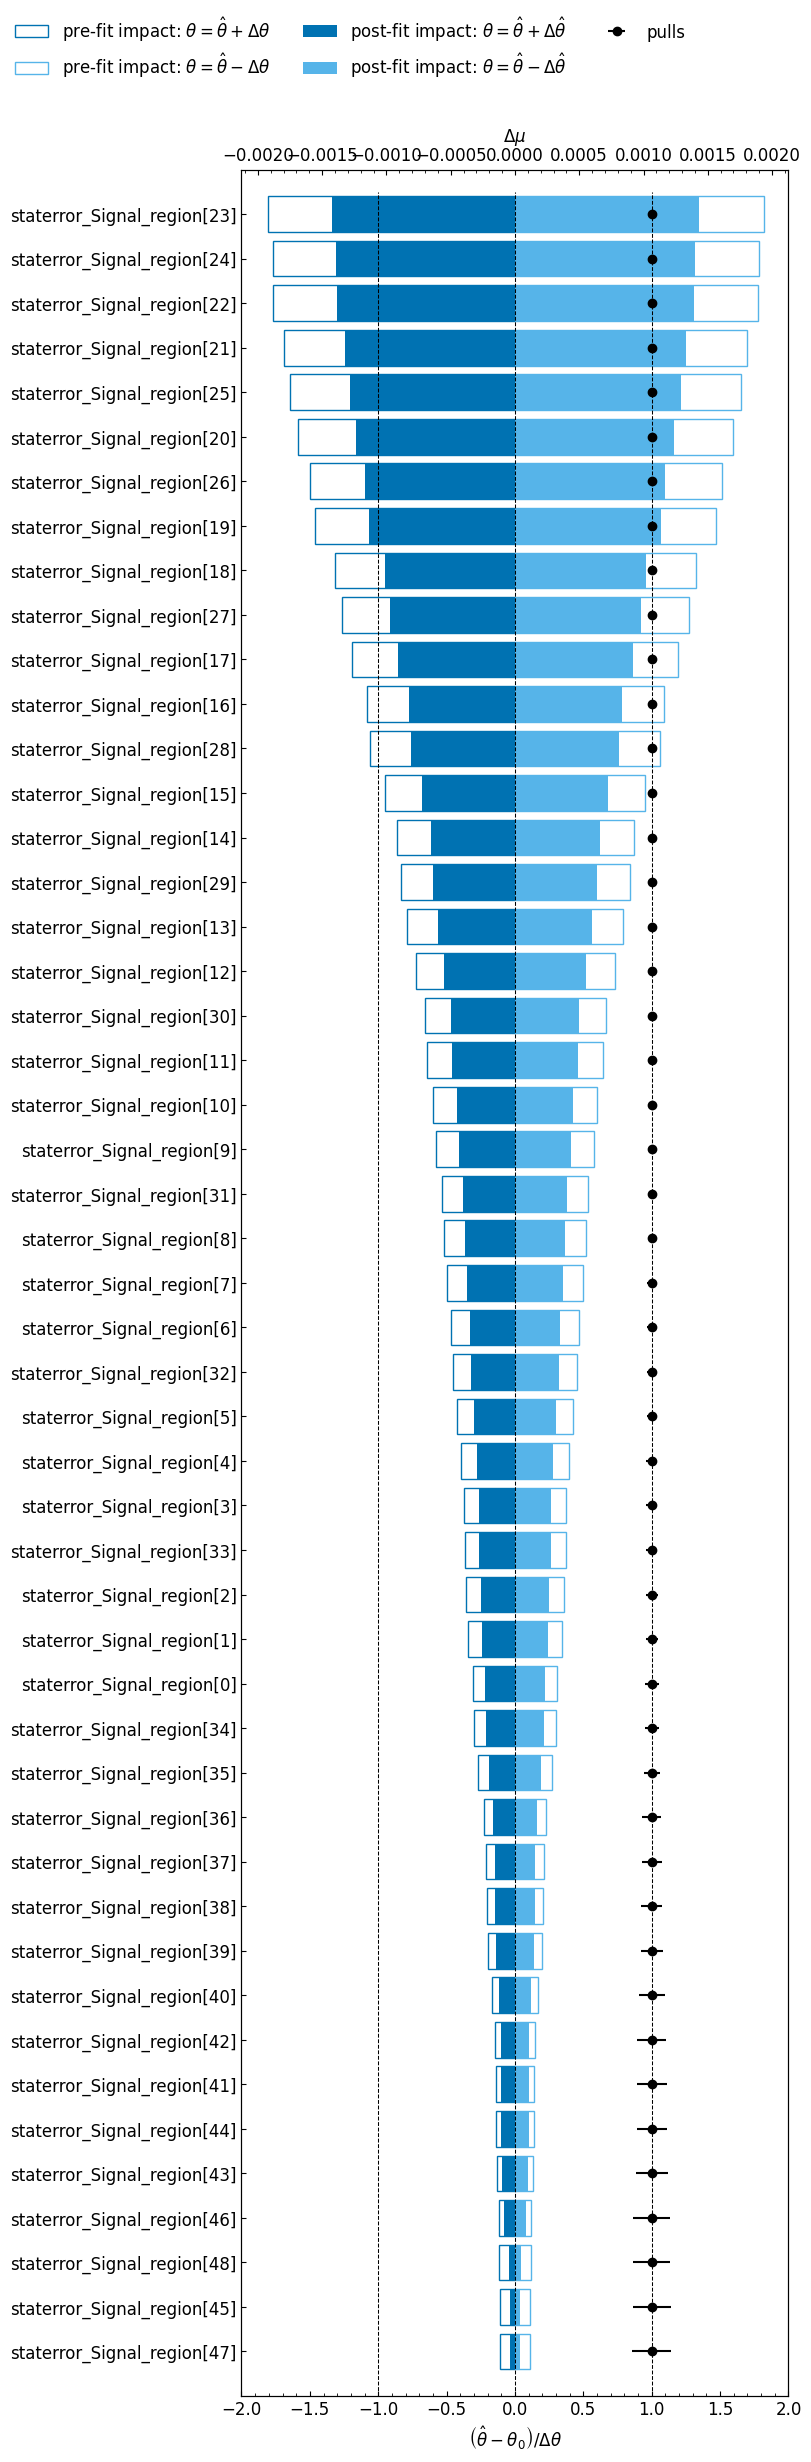

In [30]:
cabinetry.visualize.ranking(ranking_results)

In [31]:
asimov_data = cabinetry.model_utils.asimov_data(model)
